In [73]:
# !pip install xlrd

In [74]:
import warnings
warnings.filterwarnings('ignore')

In [75]:
import os
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

dataset = pd.read_excel('credit_card.xls', header=1, index_col=0)
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30000 entries, 1 to 30000
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype
---  ------                      --------------  -----
 0   LIMIT_BAL                   30000 non-null  int64
 1   SEX                         30000 non-null  int64
 2   EDUCATION                   30000 non-null  int64
 3   MARRIAGE                    30000 non-null  int64
 4   AGE                         30000 non-null  int64
 5   PAY_0                       30000 non-null  int64
 6   PAY_2                       30000 non-null  int64
 7   PAY_3                       30000 non-null  int64
 8   PAY_4                       30000 non-null  int64
 9   PAY_5                       30000 non-null  int64
 10  PAY_6                       30000 non-null  int64
 11  BILL_AMT1                   30000 non-null  int64
 12  BILL_AMT2                   30000 non-null  int64
 13  BILL_AMT3                   30000 non-null  int64
 14  BILL_AMT4  

In [76]:
dataset.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
ID,,,,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,-2,3913,3102,689,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,2,2682,1725,2682,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,0,29239,14027,13559,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,0,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,0,8617,5670,35835,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [77]:
dataset.isna().sum()

LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default payment next month    0
dtype: int64

In [78]:
import numpy as np

In [79]:
model_features = list(set(dataset.columns).difference({"ID", "default payment next month"}))
target = ["default payment next month"]
X = dataset[model_features]
y = dataset[target]

In [80]:
id_pos = np.where(y.values.reshape(-1) == 1)[0]
id_neg = np.where(y.values.reshape(-1) == 0)[0]

In [81]:
np.random.shuffle(id_pos)
np.random.shuffle(id_neg)

In [82]:
# Tập train:
id_train_neg = id_neg[:10000] 
id_train_pos = id_pos[:500]
id_train = np.concatenate((id_train_neg, id_train_pos), axis = 0)

In [83]:
# Tập val:
id_val_neg = id_neg[10000:12000]
id_val_pos = id_pos[500:600]
id_val = np.concatenate((id_val_neg, id_val_pos), axis = 0)

In [84]:
# Tập test:
id_test_neg = id_neg[14000:16000]
id_test_pos = id_pos[700:800]
id_test = np.concatenate((id_test_neg, id_test_pos), axis = 0)

In [85]:
# khởi tạo dataset
data_train = dataset.iloc[id_train]
data_val = dataset.iloc[id_val]
data_test = dataset.iloc[id_test] 

In [86]:
print('data train shape: ', data_train.shape)
print('data val shape: ', data_val.shape)
print('data test shape: ', data_test.shape)

data train shape:  (10500, 24)
data val shape:  (2100, 24)
data test shape:  (2100, 24)


<h1>Xây dựng model</h1>

In [87]:
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
import matplotlib.pyplot as plt

In [88]:
model1 = RandomForestClassifier(n_estimators=100,
                                max_depth=5,
                                min_samples_split=200,
                                class_weight=None,
                                max_features=10)

In [89]:
model2 = RandomForestClassifier(n_estimators=500, 
                                max_depth=10, 
                                min_samples_split=400, 
                                random_state=12, 
                                class_weight="balanced",
                                max_features="auto")

In [90]:
model3 = RandomForestClassifier(n_estimators=800, 
                                max_depth=10, 
                                min_samples_split=200, 
                                random_state=12, 
                                class_weight="balanced",
                                max_features="sqrt")

In [91]:
def _tunning_model(model , X_train, y_train, X_dev, y_dev):
  model.fit(X_train, y_train)
  model_predictions = model.predict_proba(X_dev)
  model_roc_score = roc_auc_score(y_dev, 
                                  model_predictions[:,1])
  return model, model_roc_score

In [92]:
model1, model1_roc_score = _tunning_model(model1, 
                                          data_train[model_features], data_train['default payment next month'],
                                          data_val[model_features], data_val['default payment next month'])
print('model 1 ROC score on dev dataset: ', model1_roc_score)

model 1 ROC score on dev dataset:  0.7756075


In [93]:
model2, model2_roc_score = _tunning_model(model2, 
                                          data_train[model_features], data_train['default payment next month'],
                                          data_val[model_features], data_val['default payment next month'])
print('model 2 ROC score on dev dataset: ', model2_roc_score)

model 2 ROC score on dev dataset:  0.7624600000000001


In [94]:
model3, model3_roc_score = _tunning_model(model3, 
                                          data_train[model_features], data_train['default payment next month'],
                                          data_val[model_features], data_val['default payment next month'])
print('model 3 ROC score on dev dataset: ', model3_roc_score)

model 3 ROC score on dev dataset:  0.76368


<h1>Over Sampling</h1>

In [133]:
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.datasets import make_classification
from sklearn.svm import LinearSVC
from sklearn.calibration import calibration_curve, CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.pipeline import Pipeline

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler
from imblearn.base import BaseSampler

In [96]:
model_smote = RandomForestClassifier(n_estimators=500, 
                                max_depth=10, 
                                min_samples_split=400, 
                                random_state=12, 
                                class_weight="balanced",
                                max_features="auto")

In [97]:
pipe = make_pipeline(RandomOverSampler(sampling_strategy=1, random_state=0), model_smote)
pipe.fit(data_train[model_features], data_train['default payment next month'])

Pipeline(steps=[('randomoversampler',
                 RandomOverSampler(random_state=0, sampling_strategy=1)),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        max_features='auto',
                                        min_samples_split=400, n_estimators=500,
                                        random_state=12))])

In [98]:
Pipeline(memory=None,
         steps=[('randomoversampler',
                 RandomOverSampler(random_state=0)),
                ('randomforestclassifier',
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight='balanced',
                                        criterion='gini', max_depth=10,
                                        max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
                                        min_samples_leaf=1,
                                        min_samples_split=400,
                                        min_weight_fraction_leaf=0.0,
                                        n_estimators=500, n_jobs=None,
                                        oob_score=False, random_state=12,
                                        verbose=0, warm_start=False))],
         verbose=False)

Pipeline(steps=[('randomoversampler', RandomOverSampler(random_state=0)),
                ('randomforestclassifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=10,
                                        max_features='auto',
                                        min_samples_split=400, n_estimators=500,
                                        random_state=12))])

In [99]:
model_smote_predictions = pipe.predict_proba(data_test[model_features])
model_smote_pred_label = pipe.predict(data_test[model_features]) 
model_smote_roc_score = roc_auc_score(data_test['default payment next month'], model_smote_predictions[:,1])
model_smote_f1_score = f1_score(data_test['default payment next month'], model_smote_pred_label)
print('random forest roc score on test: ', model_smote_roc_score)
print('random forest f1 score on test: ', model_smote_f1_score)

random forest roc score on test:  0.7974899999999999
random forest f1 score on test:  0.23689320388349516


In [100]:
model_predictions = model2.predict_proba(data_test[model_features])
model_pred_label = model2.predict(data_test[model_features]) 
model_roc_score = roc_auc_score(data_test['default payment next month'], model_predictions[:,1])
model_f1_score = f1_score(data_test['default payment next month'], model_pred_label)
print('random forest roc score on test: ', model_roc_score)
print('random forest f1 score on test: ', model_f1_score)

random forest roc score on test:  0.806555
random forest f1 score on test:  0.24535315985130107


<h1>SMOTE And Adasyn</h1>

In [117]:
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import ADASYN
from imblearn.over_sampling import (SMOTE, BorderlineSMOTE, SVMSMOTE, SMOTENC, KMeansSMOTE)
from imblearn.over_sampling import RandomOverSampler
from imblearn.base import BaseSampler
from sklearn.cluster import MiniBatchKMeans as MiniKM

clf = MiniKM(n_clusters=100, random_state=0)

<h3>Random Forest</h3>

In [118]:
rf_clf = RandomForestClassifier(n_estimators=500, 
                                max_depth=10, 
                                min_samples_split=400, 
                                random_state=12, 
                                class_weight="balanced",
                                max_features="auto")

In [119]:
smotes = {0 : 'SMOTE',
          1 : 'BorderlineSMOTE',
          2 : 'SVMSMOTE',
          3 : 'SMOTENC',
          4 : 'KMeansSMOTE',
          5 : 'ADASYN'}

In [137]:
result_dict = {}

categorical_feature_indices = [2, 10]
for i, sampler in enumerate((SMOTE(sampling_strategy = 1, random_state=0),
                BorderlineSMOTE(sampling_strategy = 1, random_state=0, kind='borderline-1'),
                SVMSMOTE(sampling_strategy = 1, random_state=0),
                SMOTENC(categorical_features=categorical_feature_indices, sampling_strategy=1, random_state=0),
                KMeansSMOTE(sampling_strategy=1, random_state=0, k_neighbors=10,
                            kmeans_estimator=clf, cluster_balance_threshold=0.05),
                ADASYN(sampling_strategy = 1, random_state=0))):

    X, y =  sampler.fit_resample(data_train[model_features], data_train['default payment next month'])
    print(f"Before: {data_train['default payment next month'].value_counts()}")
    print(f"After: {y.value_counts()}")
  
    pipe_line = make_pipeline(sampler, rf_clf)
    pipe_line.fit(data_train[model_features], data_train['default payment next month'])
    rf_predictions = pipe_line.predict_proba(data_test[model_features])
    rf_pred_label = pipe_line.predict(data_test[model_features]) 
    rf_roc_score = roc_auc_score(data_test['default payment next month'], rf_predictions[:,1])
    rf_f1_score = f1_score(data_test['default payment next month'], rf_pred_label)
    result_dict[smotes[i]] = [round(rf_roc_score, 2), round(rf_f1_score, 2)]
    print('-'*100)
    print('SMOTE method: ', smotes[i])
    print('random forest roc score on test: ', rf_roc_score)
    print('random forest f1 score on test: ', rf_f1_score)
    print('='*100)


Before: default payment next month
0    10000
1      500
Name: count, dtype: int64
After: default payment next month
0    10000
1    10000
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
SMOTE method:  SMOTE
random forest roc score on test:  0.7576350000000001
random forest f1 score on test:  0.22357723577235772
Before: default payment next month
0    10000
1      500
Name: count, dtype: int64
After: default payment next month
0    10000
1    10000
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
SMOTE method:  BorderlineSMOTE
random forest roc score on test:  0.760355
random forest f1 score on test:  0.25
Before: default payment next month
0    10000
1      500
Name: count, dtype: int64
After: default payment next month
0    10000
1     6173
Name: count, dtype: int64
----------------------------------------------------------------

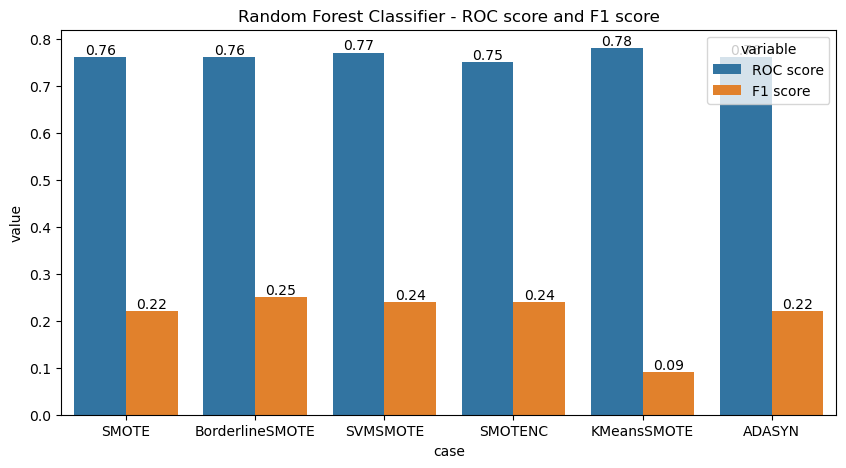

In [138]:
dfplot = pd.DataFrame(result_dict).T.reset_index()
dfplot.columns = ['case', 'ROC score', 'F1 score']
dfplot = pd.melt(dfplot, id_vars= 'case', value_vars= ['ROC score', 'F1 score'])

# Plot:
plt.figure(figsize=(10, 5))
ax = sns.barplot(data = dfplot, x = 'case', y = 'value', hue = 'variable')
plt.title('Random Forest Classifier - ROC score and F1 score')
for i in range(dfplot.variable.nunique()):
    plt.bar_label(ax.containers[i])
plt.show()

<h3>Gradient Bossting</h3>

In [140]:
from sklearn.tree import DecisionTreeClassifier

In [141]:
result_dict = {}

categorical_feature_indices = [2, 10]
for i, sampler in enumerate((SMOTE(sampling_strategy=1, random_state=0),
                              BorderlineSMOTE(sampling_strategy=1, random_state=0, kind='borderline-1'),
                              SVMSMOTE(sampling_strategy=1, random_state=0),
                              SMOTENC(categorical_features=categorical_feature_indices, sampling_strategy=1, random_state=0),
                              KMeansSMOTE(sampling_strategy=1, random_state=0, k_neighbors=10,
                                          kmeans_estimator=clf, cluster_balance_threshold=0.05),
                              ADASYN(sampling_strategy=1, random_state=0))):

    X, y = sampler.fit_resample(data_train[model_features], data_train['default payment next month'])
    print(f"Before: {data_train['default payment next month'].value_counts()}")
    print(f"After: {y.value_counts()}")

    pipe_line = make_pipeline(sampler, DecisionTreeClassifier())
    pipe_line.fit(data_train[model_features], data_train['default payment next month'])
    dt_predictions = pipe_line.predict_proba(data_test[model_features])
    dt_pred_label = pipe_line.predict(data_test[model_features])
    dt_roc_score = roc_auc_score(data_test['default payment next month'], dt_predictions[:, 1])
    dt_f1_score = f1_score(data_test['default payment next month'], dt_pred_label)
    result_dict[smotes[i]] = [round(dt_roc_score, 2), round(dt_f1_score, 2)]
    print('-' * 100)
    print('SMOTE method: ', smotes[i])
    print('Decision Tree roc score on test: ', dt_roc_score)
    print('Decision Tree f1 score on test: ', dt_f1_score)
    print('=' * 100)

Before: default payment next month
0    10000
1      500
Name: count, dtype: int64
After: default payment next month
0    10000
1    10000
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
SMOTE method:  SMOTE
Decision Tree roc score on test:  0.5307499999999999
Decision Tree f1 score on test:  0.10140845070422534
Before: default payment next month
0    10000
1      500
Name: count, dtype: int64
After: default payment next month
0    10000
1    10000
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
SMOTE method:  BorderlineSMOTE
Decision Tree roc score on test:  0.534
Decision Tree f1 score on test:  0.10666666666666667
Before: default payment next month
0    10000
1      500
Name: count, dtype: int64
After: default payment next month
0    10000
1     6173
Name: count, dtype: int64
----------------------------------------------------

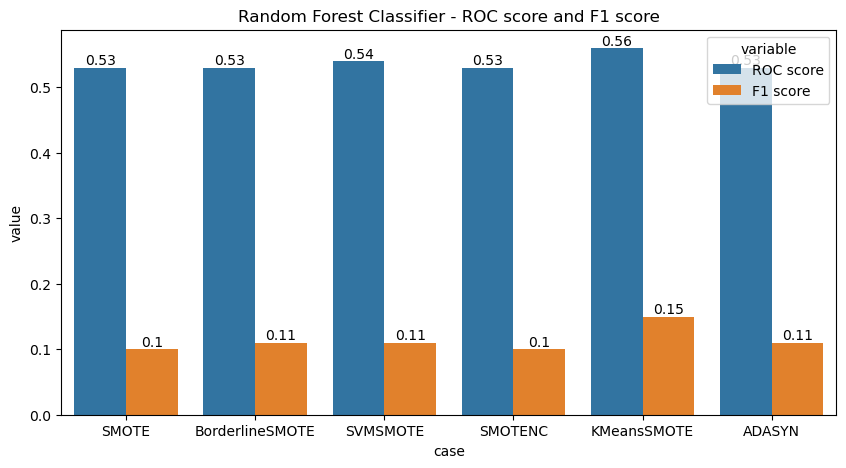

In [142]:
dfplot = pd.DataFrame(result_dict).T.reset_index()
dfplot.columns = ['case', 'ROC score', 'F1 score']
dfplot = pd.melt(dfplot, id_vars= 'case', value_vars= ['ROC score', 'F1 score'])

# Plot:
plt.figure(figsize=(10, 5))
ax = sns.barplot(data = dfplot, x = 'case', y = 'value', hue = 'variable')
plt.title('Random Forest Classifier - ROC score and F1 score')
for i in range(dfplot.variable.nunique()):
    plt.bar_label(ax.containers[i])
plt.show()

<h3>Logistic Regression</h3>

In [143]:
from sklearn.linear_model import LogisticRegression

In [144]:
result_dict = {}

categorical_feature_indices = [2, 10]
for i, sampler in enumerate((SMOTE(sampling_strategy=1, random_state=0),
                              BorderlineSMOTE(sampling_strategy=1, random_state=0, kind='borderline-1'),
                              SVMSMOTE(sampling_strategy=1, random_state=0),
                              SMOTENC(categorical_features=categorical_feature_indices, sampling_strategy=1, random_state=0),
                              KMeansSMOTE(sampling_strategy=1, random_state=0, k_neighbors=10,
                                          kmeans_estimator=clf, cluster_balance_threshold=0.05),
                              ADASYN(sampling_strategy=1, random_state=0))):

    X, y = sampler.fit_resample(data_train[model_features], data_train['default payment next month'])
    print(f"Before: {data_train['default payment next month'].value_counts()}")
    print(f"After: {y.value_counts()}")

    pipe_line = make_pipeline(sampler, LogisticRegression())
    pipe_line.fit(data_train[model_features], data_train['default payment next month'])
    lr_predictions = pipe_line.predict_proba(data_test[model_features])
    lr_pred_label = pipe_line.predict(data_test[model_features])
    lr_roc_score = roc_auc_score(data_test['default payment next month'], lr_predictions[:, 1])
    lr_f1_score = f1_score(data_test['default payment next month'], lr_pred_label)
    result_dict[smotes[i]] = [round(lr_roc_score, 2), round(lr_f1_score, 2)]
    print('-' * 100)
    print('SMOTE method: ', smotes[i])
    print('Logistic Regression roc score on test: ', lr_roc_score)
    print('Logistic Regression f1 score on test: ', lr_f1_score)
    print('=' * 100)

Before: default payment next month
0    10000
1      500
Name: count, dtype: int64
After: default payment next month
0    10000
1    10000
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
SMOTE method:  SMOTE
Logistic Regression roc score on test:  0.64964
Logistic Regression f1 score on test:  0.11635220125786164
Before: default payment next month
0    10000
1      500
Name: count, dtype: int64
After: default payment next month
0    10000
1    10000
Name: count, dtype: int64
----------------------------------------------------------------------------------------------------
SMOTE method:  BorderlineSMOTE
Logistic Regression roc score on test:  0.66289
Logistic Regression f1 score on test:  0.11969111969111969
Before: default payment next month
0    10000
1      500
Name: count, dtype: int64
After: default payment next month
0    10000
1     6173
Name: count, dtype: int64
-------------------------------------

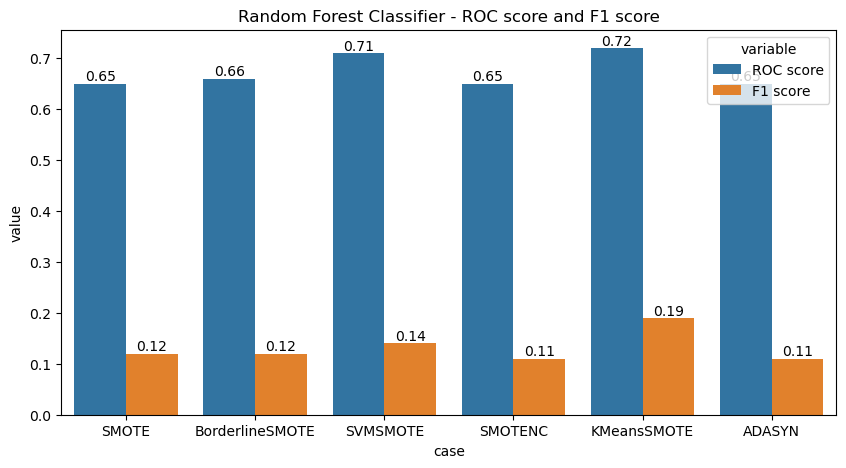

In [145]:
dfplot = pd.DataFrame(result_dict).T.reset_index()
dfplot.columns = ['case', 'ROC score', 'F1 score']
dfplot = pd.melt(dfplot, id_vars= 'case', value_vars= ['ROC score', 'F1 score'])

# Plot:
plt.figure(figsize=(10, 5))
ax = sns.barplot(data = dfplot, x = 'case', y = 'value', hue = 'variable')
plt.title('Random Forest Classifier - ROC score and F1 score')
for i in range(dfplot.variable.nunique()):
    plt.bar_label(ax.containers[i])
plt.show()